In [1]:
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
import numpy as np
import pandas as pd
import  gym
import seaborn as sns
import matplotlib.pyplot as plt
from gym_anytrading.envs import StocksEnv
from finta import TA
import os
import tensorboard
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

In [2]:
df = pd.read_csv("../../../data/all_stocks_5yr.csv")

In [3]:
df.drop('Name',axis=1,inplace=True)

In [4]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df[['MACD', 'MACD_signal']] = TA.MACD(df)
df.fillna(0, inplace=True)
df.set_index('Date',inplace=True)

In [5]:
x_train, x_test = train_test_split(df, test_size=0.1)
del df

In [6]:
models_dir = "models/A2C"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)


def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume', 'SMA', 'RSI', 'OBV', 'MACD', 'MACD_signal']].to_numpy()[start:end]
    return prices, signal_features


class MyCustomEnv(StocksEnv):
    _process_data = add_signals


env_train = MyCustomEnv(df=x_train, window_size=12, frame_bound=(12, x_train.shape[0]))
env_maker = lambda: env_train
env = DummyVecEnv([env_maker])

timesteps = 10_000

model = A2C('MlpPolicy', env=env_train, verbose=1, tensorboard_log=logdir)
for i in range(1, 30):
    model.learn(total_timesteps=timesteps, reset_num_timesteps=False, tb_log_name="A2C")
    model.save(f"{models_dir}/A2C{i * timesteps}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/A2C_0
------------------------------------
| time/                 |          |
|    fps                | 207      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.621   |
|    explained_variance | -0.00278 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 44.7     |
|    value_loss         | 7.51e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 289      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.625   |
|    explained_variance | 0.00413  |
|    learning_rate      | 0.0007

| Metric                    | Description                                                                       |
|---------------------------|-----------------------------------------------------------------------------------|
| time/fps                  | Number of steps per second taken by the model during training.                    |
| iterations                | Number of iterations completed during training.                                   |
| time_elapsed              | Total time elapsed during training in seconds.                                    |
| total_timesteps           | Total number of timesteps taken by the model during training.                     |
| train/entropy_loss        | Entropy loss of the policy during training. The goal is to have enough entropy... |
| train/explained_variance  | Explained variance of the value function during training. The goal is to have ... |
| train/learning_rate       | Learning rate of the optimizer during training. It is adjusted according to th... |
| train/n_updates           | Number of updates made to the model during training.                               |
| train/policy_loss         | Policy loss of the A2C algorithm during training. The goal is to minimize it t... |
| train/value_loss          | Value function loss of the A2C algorithm during training. The goal is to minimi... |


info {'total_reward': 0.0, 'total_profit': 1.6245130378657486, 'position': 1}


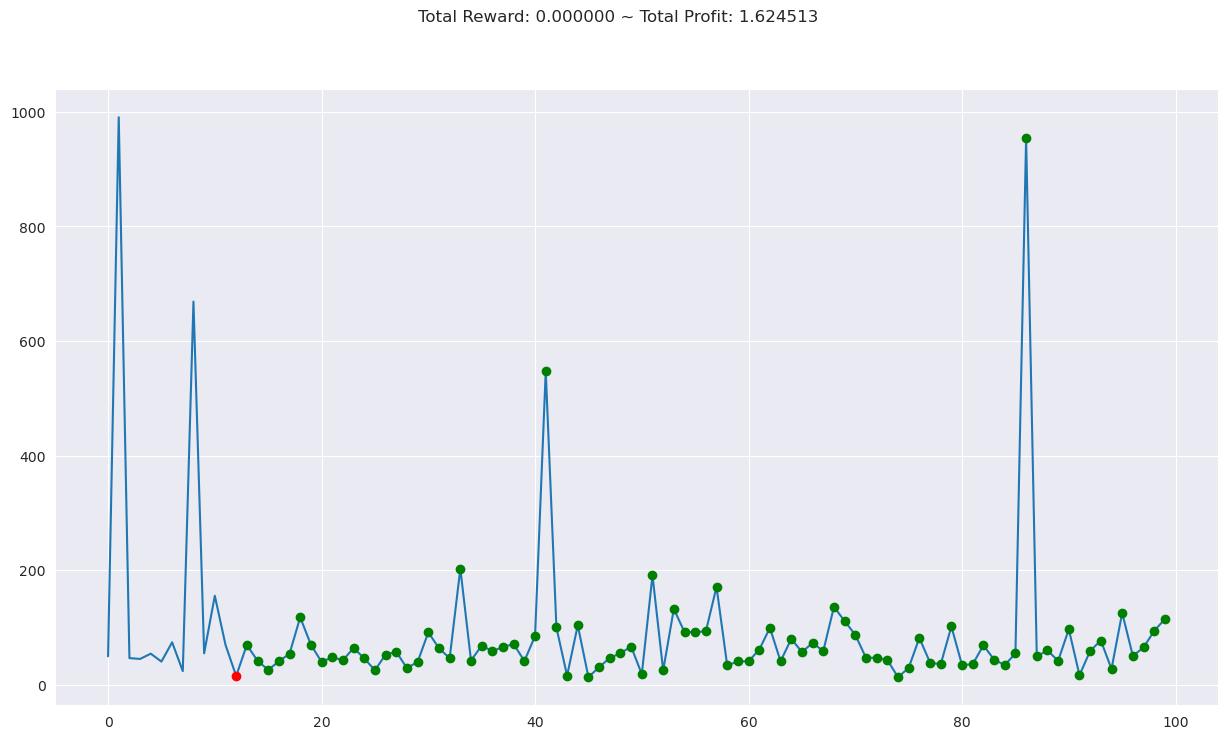

In [7]:
env = MyCustomEnv(df=x_test, window_size=12, frame_bound=(12, 100))
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
plt.figure(figsize=(15, 8))
plt.cla()
env.render_all()
plt.show()

In [11]:
%load_ext tensorboard
log_dir = 'logs/'  # the directory where you saved your TensorBoard logs
tensorboard_callback = TensorBoard(log_dir=log_dir)

%tensorboard --logdir logs/  # visualize the logs in TensorBoard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

| Metric                     | Definition                               | Goal                                                       |
|----------------------------|------------------------------------------|------------------------------------------------------------|
| `time/fps`                 | Steps per second                         | Maximize                                                   |
| `train/entropy_loss`       | Entropy loss of policy                    | High enough for exploration, but not too high to prevent convergence |
| `train/explained_variance` | Explained variance of value function   | High enough to accurately estimate state values              |
| `train/learning_rate`      | Learning rate of optimizer                | Adjust according to learning schedule and convergence       |
| `train/policy_loss`        | Policy loss of A2C                        | Minimize to improve policy performance                       |
| `train/value_loss`         | Value function loss of A2C                | Minimize to improve value function accuracy                  |
